### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import re
import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


### Helper functions

In [2]:
# preprocess given documents
def preprocess_data(data):

    # replace unnecessary characters with space
    s = re.sub(r"\\n", " ", str(data).lower())
    s = re.sub(r":", "", s) 
    s = re.sub(r"\.", " ", s)
    s = re.sub(r"\,", " ", s)
    s = re.sub(r"\!", " ", s)
    s = re.sub(r"\;", " ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"[^A-Za-z0-9^+-=]", " ", s)    

    # tokenize the lower cased string 
    s = s.split()  
    
    # standard stop words list
    stop_words = list(stopwords.words('english'))    

    # Remove stop_words
    s = [w for w in s if not w in stop_words] 

    # convert tokens back to document
    s = " ".join(s).rstrip()  

    return str(s)

def read_data_into_dataframe(dir_path, filename):
    
    doc_list = []
  
    with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as f:
        doc_list = f.read().split('\n\n')        
        
    return pd.DataFrame(data=np.array(doc_list).reshape(-1, 1), columns=['doc'])

def create_final_dataset():
    # textfile path
    dir_path = 'data/'

    df_corpus_1, corpus_label_1 = read_data_into_dataframe(dir_path, "28054-0.txt"), "Fyodor Dostoyevsky"
    df_corpus_2, corpus_label_2 = read_data_into_dataframe(dir_path, "pg1661.txt"), "Arthur Conan Doyle"
    df_corpus_3, corpus_label_3 = read_data_into_dataframe(dir_path, "pg31100.txt"), "Jane Austen"

    df_corpus_1['label'] = corpus_label_1
    df_corpus_2['label'] = corpus_label_2
    df_corpus_3['label'] = corpus_label_3

    df_corpus_1 = df_corpus_1.iloc[29:6083]
    df_corpus_2 = df_corpus_2.iloc[21:2567]
    df_corpus_3 = df_corpus_3.iloc[40:11533]
    
    corpus_1_len = df_corpus_1.shape[0]
    corpus_2_len = df_corpus_2.shape[0]
    corpus_3_len = df_corpus_3.shape[0]
    
    # Balance all 3 classes
    print(df_corpus_1.sample(frac=corpus_2_len/corpus_1_len).shape,
                         df_corpus_2.shape,
                         df_corpus_3.sample(frac=corpus_2_len/corpus_3_len).shape)
    
    # combining all corpus into dataframe of documents
    df_docs = pd.concat([df_corpus_1.sample(frac=corpus_2_len/corpus_1_len),
                         df_corpus_2,
                         df_corpus_3.sample(frac=corpus_2_len/corpus_3_len)])

    # to make sure all docs are of string type
    df_docs.doc = df_docs.doc.astype(str)
    
    df_docs.reset_index(inplace=True, drop=True)
    
    return df_docs  

def split_data(data):
    # shuffle dataset
    data = data.sample(frac=1).reset_index(drop=True)
    test_size = int(0.2*data.shape[0])
    n_len = data.shape[0]
    X_train, X_test = data.iloc[:n_len-test_size, 0], data.iloc[-test_size:, 0]
    y_train, y_test = data.iloc[:n_len-test_size, 1], data.iloc[-test_size:, 1]
    return X_train, X_test, y_train, y_test

def feature_extraction(X_train, X_test):
    tfidf = TfidfVectorizer()
    tfidf_ = tfidf.fit(X_train)    
    return tfidf_.transform(X_train), tfidf_.transform(X_test)

def plot_loss(train_loss, val_loss, title):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
def perform_cross_validation(X, y, fold, isSGD):
    print('Is it stochastic gradient descent?: ', isSGD)
    kf = KFold(n_splits=fold)    
    scores = []
    train_loss = []
    val_loss = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lr = LogisticRegression(X_test, y_test, isSGD)
        lr.fit(X_train, y_train)
        preds, t_loss, v_loss = lr.predict(X_test)
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        scores.append(accuracy_score(np.argmax(y_test, axis=1), np.array(preds)))
        
    return scores, train_loss, val_loss

def classify_with_mlp(input_shape, x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=25, batch_size=128, validation_split = 0.1)
    score = model.evaluate(x_test, y_test, batch_size=128)
    return score, history
    

### Dataset manipulation

In [3]:
## Create dataset ##

df_docs = create_final_dataset()

(2546, 2) (2546, 2) (2546, 2)


In [4]:
## Data Cleaning and Preprocessing ##

df_docs.doc = df_docs.doc.apply(lambda x: preprocess_data(x))
df_docs.label = df_docs.label.replace({"Fyodor Dostoyevsky":0, "Arthur Conan Doyle":1, "Jane Austen":2})
df = df_docs[df_docs.doc != ""]

In [5]:
## Split data into train and test sets ##

X_train, X_test, y_train, y_test = split_data(df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5924,) (1481,) (5924,) (1481,)


In [6]:
## Feature extraction - TFIDF ##

tfidf_train, tfidf_test = feature_extraction(X_train, X_test)
print(tfidf_train.shape, tfidf_test.shape)

(5924, 14207) (1481, 14207)


### MLP Classifier

In [310]:
## Preprocessing for keras

input_shape = (tfidf_train.shape[1],)
y_train_encoded = np_utils.to_categorical(y_train)
y_test_encoded = np_utils.to_categorical(y_test)

In [311]:
## Classification using MLP classifier

score, history = classify_with_mlp(input_shape, tfidf_train, y_train_encoded, tfidf_test, y_test_encoded)

Train on 5332 samples, validate on 593 samples
Epoch 1/25
5332/5332 [==============================] - 1s 264us/sample - loss: 1.0985 - accuracy: 0.3342 - val_loss: 1.0986 - val_accuracy: 0.3170
Epoch 2/25
5332/5332 [==============================] - 1s 220us/sample - loss: 1.0959 - accuracy: 0.3811 - val_loss: 1.0960 - val_accuracy: 0.3272
Epoch 3/25
5332/5332 [==============================] - 1s 218us/sample - loss: 1.0915 - accuracy: 0.4345 - val_loss: 1.0900 - val_accuracy: 0.4486
Epoch 4/25
5332/5332 [==============================] - 1s 222us/sample - loss: 1.0850 - accuracy: 0.5553 - val_loss: 1.0855 - val_accuracy: 0.5177
Epoch 5/25
5332/5332 [==============================] - 1s 222us/sample - loss: 1.0768 - accuracy: 0.5034 - val_loss: 1.0768 - val_accuracy: 0.3997
Epoch 6/25
5332/5332 [==============================] - 1s 223us/sample - loss: 1.0652 - accuracy: 0.6288 - val_loss: 1.0615 - val_accuracy: 0.6121
Epoch 7/25
5332/5332 [==============================] - 1s 220us/

In [312]:
# Accuracy
print("Accuracy for MLP model: %f" % (score[1]*100), "%")

Accuracy for MLP model: 86.090481 %


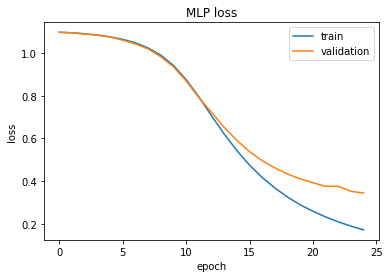

In [313]:
# plot training and validation loss
plot_loss(history.history['loss'], history.history['val_loss'], "MLP loss")

### Logistic Regression Classifier

In [7]:
class LogisticRegression():
    
    def __init__ (self, x_val, y_val, lr=0.01, epochs=100, isSGD=False):
        self.lr = lr
        self.epochs = epochs
        self.isSGD = isSGD
        self.x_val = x_val
        self.y_val = y_val
    
    def softmax(self, z):
        exps = np.exp(z)
        return exps / np.sum(exps)
    
    def categorical_cross_entropy(self, p, y_true): 
        return -np.sum(np.multiply(y_true, np.log(p))) / self.m     
    
    def evaluate_gradient(self, X, Y, _sig):
        return np.dot(X.T, (_sig - Y)) / self.m

    def gradient_descent(self, X, Y): 
        for i in range(self.epochs):            
            # train set
            z_train = np.dot(X, self.w) 
            h_train = self.softmax(z_train)
            
            # validation set
            z_val = np.dot(self.x_val, self.w)
            h_val = self.softmax(z_val)
            
            self.w = self.w - self.lr * self.evaluate_gradient(X, Y, h_train)
            
            self.train_loss[i] = self.categorical_cross_entropy(h_train, Y) 
            self.val_loss[i] = self.categorical_cross_entropy(h_val, self.y_val)

    def stochastic_gradient_descent(self, X, Y):
        for e in range(self.epochs):
            train_loss = val_loss = 0.0
            for i in range(self.m):                
                # train set
                
                # to pick random datapoint
                t_index = np.random.randint(0, self.m)
                
                x_train = X[t_index, :]
                y_train = Y[t_index]
                z_train = np.dot(x_train, self.w) 
                h_train = self.softmax(z_train)                
                
                # validation set
                
                # to pick random datapoint
                v_index = np.random.randint(0, len(self.y_val))
                
                x_val = self.x_val[v_index, :]
                y_val = self.y_val[v_index]
                z_val = np.dot(x_val, self.w) 
                h_val = self.softmax(z_val)
                
                self.w = self.w - self.lr * self.evaluate_gradient(x_train, y_train, h_train)
                train_loss += self.categorical_cross_entropy(h_train, y_train)
                val_loss += self.categorical_cross_entropy(h_val, y_val)
                
            self.train_loss[e] = train_loss        
            self.val_loss[e] = val_loss
    
    def fit(self, X, Y):   
        self.m = len(Y)
        
        # initialize weights
        self.w = np.zeros(shape=(X.shape[1], Y.shape[1]))        
        # initialize train loss array
        self.train_loss = np.zeros(self.epochs)
        # initialize validation loss array
        self.val_loss = np.zeros(self.epochs)
        
        if(self.isSGD):
            self.stochastic_gradient_descent(X, Y)
        else:
            self.gradient_descent(X, Y)       
            
    def predict_proba(self, X):    
        return self.softmax(np.dot(X, self.w))
    
    def predict(self, test):
        return np.argmax(self.predict_proba(test), axis=1), self.train_loss, self.val_loss    

In [12]:
print(tfidf_test.toarray())
tfidf_test

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<1481x14207 sparse matrix of type '<class 'numpy.float64'>'
	with 33353 stored elements in Compressed Sparse Row format>

In [315]:
%%time

# Run time: for given settings 
# within 1min for GD 
# around 8mins for SGD

learning_rate = 0.01
epochs = 100

# To run using SGD
lr = LogisticRegression(tfidf_test.todense(), y_test_encoded, epochs=epochs, lr=learning_rate, isSGD=True)

# To run using GD
# lr = LogisticRegression(tfidf_test.todense(), y_test_encoded, epochs=epochs, lr=learning_rate, isSGD=False)

lr.fit(tfidf_train.todense(), y_train_encoded)
preds, train_loss, val_loss = lr.predict(tfidf_test.todense())


Wall time: 8min 4s


In [316]:
preds = np.array(preds)
true = np.argmax(y_test_encoded, axis=1)

In [317]:
print("Accuracy: %f" % (accuracy_score(true, preds)*100), "%")

Accuracy: 77.717758 %


In [318]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       485
           1       0.87      0.58      0.69       498
           2       0.68      0.92      0.78       498

    accuracy                           0.78      1481
   macro avg       0.80      0.78      0.77      1481
weighted avg       0.80      0.78      0.77      1481



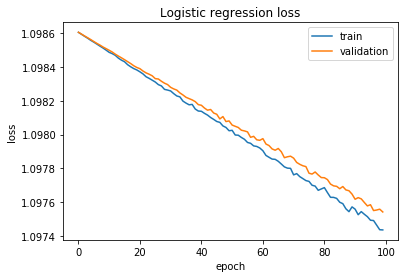

In [319]:
# plot training and valiation loss

plot_loss(train_loss, val_loss, "Logistic regression loss")

### 10-fold Cross-validation with Logistic Regression using Gradient Descent

In [320]:
%%time 

# Run time for given settings: 4mins
# to run using GD
scores, cv_train_loss, cv_val_loss = perform_cross_validation(tfidf_train.todense(), y_train_encoded, 10, False)

# to run using SGD
# scores, cv_train_loss, cv_val_loss = perform_cross_validation(tfidf_train.todense(), y_train_encoded, 10, True)

Is it stochastic gradient descent?:  False
Wall time: 4min 25s


In [321]:
print("Accuracy Scores:")
print(scores)

Accuracy Scores:
[0.35581787521079256, 0.33220910623946037, 0.3490725126475548, 0.35413153456998314, 0.3102866779089376, 0.3277027027027027, 0.3564189189189189, 0.33614864864864863, 0.3141891891891892, 0.31756756756756754]


In [322]:
# extract minimum loss
max_score = np.max(scores)

m_index = [i for i,j in enumerate(scores) if j == max_score]
min_train_loss = cv_train_loss[m_index[0]]
min_val_loss = cv_val_loss[m_index[0]]

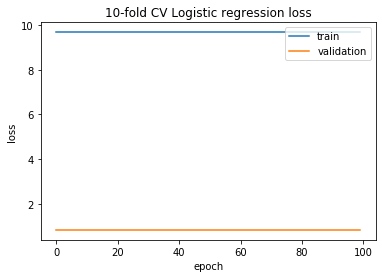

In [324]:
# plot training and valiation loss

plot_loss(min_train_loss, min_val_loss, "10-fold CV Logistic regression loss")

### Comparision and Analysis 

- Multilayer perceptron(MLP) is giving about 88% accuracy with just 25 epochs. On other hand, Logistic regression(LR) is giving 77% accuracy using 100 epochs. <br>
- If we compare train vs validation loss plot for both, we can clearly see that, for MLP both losses are smoothly reducing with each epoch. But for LR, reduction in loss is not smooth and it is very very small reduction. So, we can assume that it would take huge number of epochs(i.e 2000/3000) for convergence in LR. <br>
- Running time for MLP with 25 epochs is about 25 seconds only. On other hand LR with gradient descent takes around 1min and LR with stochastic gradient descent takes around 8mins to complete 100 epochs. <br>
- When we run LR with 10-fold cross-validation, we get very low accuracy scores for each fold. This suggests that LR is kind of underfitting when dataset size is low. So, LR model is not complex enough as compared to neural nets to perform tasks such as document classification for multiple classes.<br>

- Hence, neural network(MLP) is clear winner for the given task of document classification